In [1]:
class Training_Data:
    
    def __init__(self, data_file):
        self.data_file = data_file
        
    def load_data(self):
        
        import os
    
        file_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', self.data_file))    
        with open(file_path, 'rt', encoding='utf-8') as tf:
            loaded_ad = tf.read().split('\n')
        job_ads = []
        job_ads = [self.parse_data(item) for item in loaded_ad[:-1]]
        self.raw_data = job_ads
        self.classes = set([item['class'] for item in job_ads])
    
    def parse_data(self, input_line):
        
        cur_text = input_line.split('`')
        ret_data = {}
        ret_data['id'] = cur_text[1]
        ret_data['company'] = cur_text[3]
        ret_data['position'] = cur_text[5]
        ret_data['url'] = cur_text[7]
        ret_data['desc'] = cur_text[9]
        ret_data['class'] = ''.join(cur_text[11:]).replace(',NA', '')
    
        return ret_data
    
    def create_training_set(self, labels):
        
        self.label_dict = {}
        for i, item in enumerate(labels):
            self.label_dict[item] = i + 1
        self.label = [self.label_dict[item['class']] if item['class'] in self.label_dict else 0 for item in self.raw_data]
        self.label_names = [item['class'] if item['class'] in self.label_dict else 'Other' for item in self.raw_data]
        
    def vectorize(self):
        
        def remove_white_space(in_text):
            
            on_text = in_text[:].replace(u'\xa0', ' ')
            while on_text.find('  ') > -1:
                on_text = on_text.replace('  ', ' ')
                
            return on_text
        
        self.sample_desc = [remove_white_space(item['desc']) for item in self.raw_data]
        self.sample_title = [remove_white_space(item['position']) for item in self.raw_data]
        
        from sklearn.feature_extraction.text import TfidfVectorizer
        import os
        os.sys.path.append('..')
        from tokenizer import Tokenizer as my_tokenizer
        tkn1 = my_tokenizer(1)
        tkn2 = my_tokenizer(2)
        tkn3 = my_tokenizer(3)
        tkn4 = my_tokenizer(4)
        desc_vectorizer = TfidfVectorizer(tokenizer=tkn2.tokenizer)
        self.sample_desc = desc_vectorizer.fit_transform(TD.sample_desc)
        title_vectorizer = TfidfVectorizer(tokenizer=tkn4.tokenizer)
        self.sample_title = title_vectorizer.fit_transform(TD.sample_title)
        
    def balance_training_set(self, balance_class):
    
        import numpy as np
        prop = np.mean([np.array(self.label) == self.label_dict[balance_class]])
        
        if prop < 0.5:
            prop = prop / (1 - prop)
            mask = [True if item == self.label_dict[balance_class] or np.random.rand() < prop else False for item in self.label]
        else:
            prop = (1 - prop) / prop
            mask = [True if item != self.label_dict[balance_class] or np.random.rand() < prop else False for item in self.label]
        sample_desc = []
        sample_title = []
        label = []
        for i, item in enumerate(mask):
            if item:
                sample_desc.append(self.sample_desc[i])
                sample_title.append(self.sample_title[i])
                label.append(self.label[i])
        return label, sample_title, sample_desc

In [2]:
import pickle
with open('trainingset.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    TD = pickle.load(f)
TD.create_training_set(['Other'])
label_vec, title_vec, desc_vec = TD.balance_training_set('Other')

In [6]:
def hold_sample(label, title, desc, prop):
    import numpy as np
    from scipy.sparse import vstack, hstack
    mask = np.random.rand(len(label))
    label_vec = []
    title_vec = []
    desc_vec = []
    for i, item in enumerate(mask):
        if item <= prop:
            label_vec.append(label[i])
            title_vec.append(title[i])
            desc_vec.append(desc[i])
    data_vec = hstack([vstack(title_vec), vstack(desc_vec)])
    label_vec = np.array(label_vec)
    sample = {'prop':prop, 'label_vec': label_vec, 'data_vec': data_vec}
    return sample

In [7]:
hold_out_sample_prop = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
hold_out_samples = []
for prop in hold_out_sample_prop:
    hold_out_samples.append(hold_sample(label_vec, title_vec, desc_vec, prop))

In [10]:
def train_NB(data_vec, label_vec, cv=10):
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.model_selection import cross_validate
    import numpy as np
    bclf = BernoulliNB()
    scores = cross_validate(bclf, data_vec, label_vec, cv=cv, scoring=['precision_macro', 'recall_macro', 'f1_macro'])
    avg_score = {}
    avg_score['test_precision_macro'] = np.mean(scores['test_precision_macro'])
    avg_score['test_recall_macro'] = np.mean(scores['test_recall_macro'])
    avg_score['test_f1_macro'] = np.mean(scores['test_f1_macro'])
    return avg_score

0.3 (289,) (289, 38969)


c:\users\nutha\jpa\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\nutha\jpa\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\nutha\jpa\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\nutha\jpa\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\nutha\jpa\lib\site-packages\sklearn\metrics\classification.py:1135: Und

0.4 (366,) (366, 38969)
0.5 (462,) (462, 38969)
0.6 (543,) (543, 38969)
0.7 (643,) (643, 38969)
0.8 (724,) (724, 38969)
0.9 (807,) (807, 38969)
1 (910,) (910, 38969)


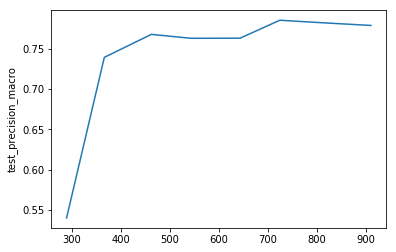

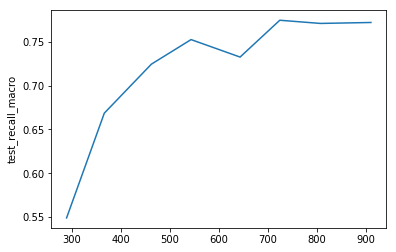

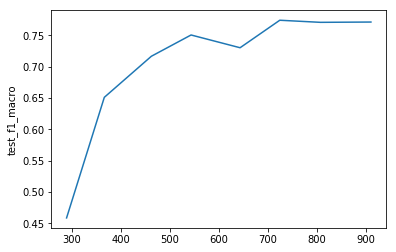

In [16]:
test_precision_macro = []
test_recall_macro = []
test_f1_macro = []
for item in hold_out_samples:
    print(item['prop'], item['label_vec'].shape, item['data_vec'].shape)
    score = train_NB(item['data_vec'], item['label_vec'])
    test_precision_macro.append(score['test_precision_macro'])
    test_recall_macro.append(score['test_recall_macro'])
    test_f1_macro.append(score['test_f1_macro'])
#print(test_precision_macro)
#print(test_recall_macro)
#print(test_f1_macro)
import matplotlib.pyplot as plt
sample_size = [item['label_vec'].shape[0] for item in hold_out_samples]
plt.plot(sample_size, test_precision_macro)
plt.ylabel('test_precision_macro')
plt.show()
plt.plot(sample_size, test_recall_macro)
plt.ylabel('test_recall_macro')
plt.show()
plt.plot(sample_size, test_f1_macro)
plt.ylabel('test_f1_macro')
plt.show()

In [ ]:
TD = Training_Data('trainingset_20180406.csv')
TD.load_data()
TD.vectorize()
import pickle
with open('trainingset.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(TD, f, pickle.HIGHEST_PROTOCOL)